#PREREQUISITES

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Importing Important Libraries***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

#DATA PRE-PROCESSING

***Importing Data***

In [ ]:
path = "/content/drive/MyDrive/Data Sets/mail_data.csv"
df = pd.read_csv(path, encoding='unicode_escape')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6213 entries, 0 to 6212
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  6213 non-null   object
 1   Message   6213 non-null   object
dtypes: object(2)
memory usage: 97.2+ KB


In [ ]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.shape

(6213, 2)

In [ ]:
#df.dropna()

***Data Cleaning***

In [ ]:
#checking duplicate entries
df.duplicated().sum()

809

In [ ]:
#removing duplicate entries
df = df.drop_duplicates(keep='first')

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.shape

(5404, 2)

***Data Encording***


*   Ham (Not Spam) -> 0
*   Spam -> 1

**Note:** *New Col 'label (Target)' is created for categories (ham,spam)*

In [ ]:
df["label"] = (df.Category == "spam").astype(int)
# df[['Message', 'label']]
df

,Category,Message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
6208,spam,Warning: Your account may have been accessed b...,1
6209,spam,Claim your prize: You've won a shopping spree ...,1
6210,spam,Limited spots available: Sign up for our works...,1
6211,spam,Upgrade to our premium plan for exclusive acce...,1


***Shuffel Data Frame***

In [ ]:
df = df.sample(frac = 1)

***Data Visualization***

*Pie Chart Visualisation of Over all Data Set*

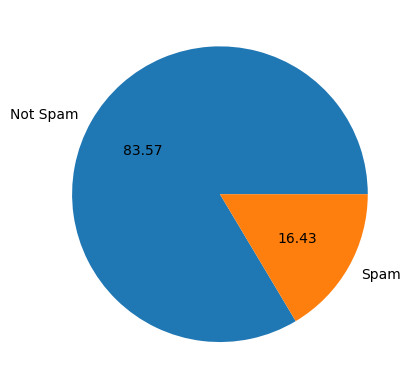

In [ ]:
plt.pie(df['label'].value_counts(), labels=["Not Spam", "Spam"], autopct = "%0.2f")
plt.show()

*Word Colud Visualisation*

In [ ]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='#FFFDD7')

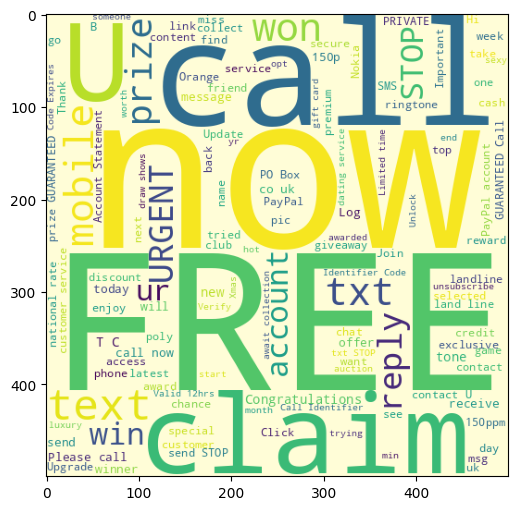

In [ ]:
#Word Cloud Representation for Spam Words
spam_wc = wc.generate(df[df['label'] == 1]['Message'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

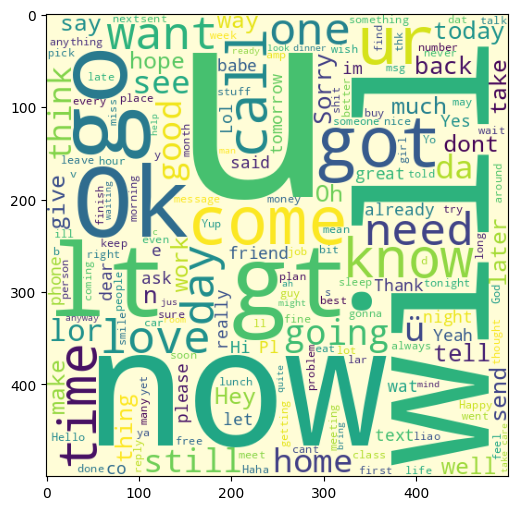

In [ ]:
#Word Cloud Representation for Ham Words
ham_wc = wc.generate(df[df['label'] == 0]['Message'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

***Splitting Data Set into traning, test and validation data set***

In [ ]:
#df.sample -> draw random sample 80% for traning ; 10% for validation ; 10% for testing
train, test, valid = np.split(df.sample(frac = 1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
len(train), len(valid), len(test)

(4323, 541, 540)

 **Converting Dataframe to Tensorflow Dataset object**

*   *Takes a DataFrame 'dataframe' as input and returns a TensorFlow Dataset object*




In [ ]:
def df_to_dataset(dataframe, shuffle = True, batch_size = 150):
  df = dataframe.copy()
  labels = df.pop('label') #target
  df = df["Message"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size = len(dataframe)) #shuffle data set
  ds = ds.batch(batch_size) #batch data sets
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

In [ ]:
list(train_data)[0]

(<tf.Tensor: shape=(150,), dtype=string, numpy=
 array([b'SYMPTOMS when U are in love: "1.U like listening songs 2.U get stopped where u see the name of your beloved 3.U won\'t get angry when your',
        b'Great escape. I fancy the bridge but needs her lager. See you tomo',
        b'Reverse is cheating. That is not mathematics.',
        b'Keep my payasam there if rinu brings',
        b'Get a brand new mobile phone by being an agent of The Mob! Plus loads more goodies! For more info just text MAT to 87021.',
        b'Want a new Video Phone? 750 anytime any network mins? Half price line rental free text for 3 months? Reply or call 08000930705 for free delivery',
        b"I'm done. I'm sorry. I hope your next space gives you everything you want. Remember all the furniture is yours. If i'm not around when you move it, just lock all the locks and leave the key with jenne.",
        b'O was not into fps then.', b'Two teams waiting for some players',
        b'Indeed and by the way it

#EMBEDDING + MODEL

***Text Embedding***

In [ ]:
#transforming our text into numbers
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, input_shape=[], output_shape=[50], trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(150, 50), dtype=float32, numpy=
array([[ 0.05166095, -0.02980816, -0.4080712 , ..., -0.1413579 ,
        -0.18601586,  0.04822091],
       [-0.04874152, -0.06167283, -0.25312325, ..., -0.37642238,
         0.0221332 ,  0.22841227],
       [ 0.15789868, -0.32147908, -0.16780034, ...,  0.05273291,
        -0.14526998,  0.09971701],
       ...,
       [ 0.16522698, -0.03618149, -0.10822411, ...,  0.16540289,
         0.11195654,  0.06855106],
       [-0.00443307, -0.0441623 ,  0.17816198, ..., -0.20903009,
        -0.1605583 ,  0.25441384],
       [ 0.27899075,  0.02110747,  0.08084821, ...,  0.21090752,
        -0.00647973,  0.17090583]], dtype=float32)>

***Model Buliding***

*Model Architecture*

*   *Forward Feed Neural Net with two 'Hidden Layers' and 'Output Layer'*



In [ ]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(units = 20, activation = 'relu', name = "hidden_layer_1"),
    tf.keras.layers.Dense(units = 5, activation = 'relu', name = "hidden_layer_2"),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid', name = "output_layer")
])

*Configuring/ Compile Model*

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
  )

*Checking Model Accuracy On Untrained Model*

In [ ]:
model.evaluate(train_data)

29/29 [==============================] - 1s 4ms/step - loss: 0.7045 - accuracy: 0.4488


[0.7045078277587891, 0.448762446641922]

***Model Summary***

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 hidden_layer_1 (Dense)      (None, 20)                1020      
                                                                 
 hidden_layer_2 (Dense)      (None, 5)                 105       
                                                                 
 output_layer (Dense)        (None, 1)                 6         
                                                                 
Total params: 48191731 (183.84 MB)
Trainable params: 48191731 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


*Model Traning on "train_data" Data Set*

In [ ]:
history = model.fit(train_data, epochs = 10, validation_data = valid_data)

Epoch 1/10
29/29 [==============================] - 8s 220ms/step - loss: 0.6311 - accuracy: 0.7661 - val_loss: 0.5289 - val_accuracy: 0.8336
Epoch 2/10
29/29 [==============================] - 4s 151ms/step - loss: 0.4186 - accuracy: 0.8383 - val_loss: 0.3405 - val_accuracy: 0.8355
Epoch 3/10
29/29 [==============================] - 4s 149ms/step - loss: 0.2636 - accuracy: 0.8469 - val_loss: 0.2491 - val_accuracy: 0.8410
Epoch 4/10
29/29 [==============================] - 4s 147ms/step - loss: 0.1863 - accuracy: 0.9137 - val_loss: 0.1914 - val_accuracy: 0.9445
Epoch 5/10
29/29 [==============================] - 4s 126ms/step - loss: 0.1159 - accuracy: 0.9843 - val_loss: 0.1293 - val_accuracy: 0.9723
Epoch 6/10
29/29 [==============================] - 2s 79ms/step - loss: 0.0590 - accuracy: 0.9919 - val_loss: 0.1005 - val_accuracy: 0.9741
Epoch 7/10
29/29 [==============================] - 2s 80ms/step - loss: 0.0321 - accuracy: 0.9947 - val_loss: 0.0887 - val_accuracy: 0.9723
Epoch 8/

**Visualize Accuracy**
*   *Traning accuracy and Validation accuracy increases very well*

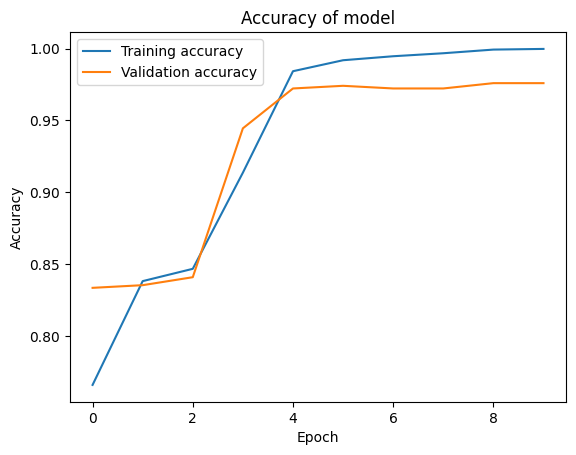

In [ ]:
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

**Visualize loss**
*   *Traning Loss and Validation Loss decreases very well*

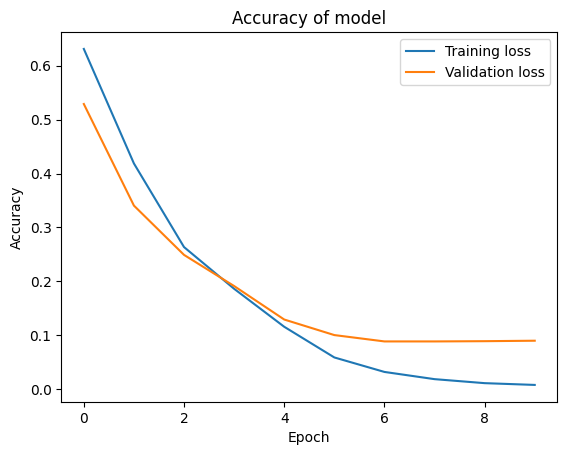

In [ ]:
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

**Model Performance**

*   *On Traning Data Set(train_data)*
*   *On Validation Data Set(valid_data)*
*   *On Testing Data Set(test_data)*

*Both data sets are new for model (not seen by model before)*


In [ ]:
model.evaluate(train_data)

29/29 [==============================] - 0s 5ms/step - loss: 0.0066 - accuracy: 0.9998


[0.0065573425963521, 0.9997686743736267]

In [ ]:
model.evaluate(valid_data)

4/4 [==============================] - 0s 6ms/step - loss: 0.0900 - accuracy: 0.9760


[0.09000038355588913, 0.975970447063446]

In [ ]:
model.evaluate(test_data)

4/4 [==============================] - 0s 7ms/step - loss: 0.0952 - accuracy: 0.9722


[0.0952044203877449, 0.9722222089767456]

***Testing Based On User Input***

In [ ]:
#Taking input mail from user in form of text
#Spam Mail example
# input_mail = ["We've detected suspicious activity on your account. Please log in immediately to verify your identity and secure your account. Failure to do so may result in account suspension."]
# input_mail = ["Make easy money from home! Join our exclusive program and start earning thousands of dollars every week. No experience required. Sign up now and take control of your financial future!"]
# input_mail = ["You've been selected as a winner of our exclusive giveaway! Claim your free iPhone X now by clicking the link below"]
# input_mail = ["Congratulations! You've been selected as the lucky winner of a free vacation to the destination of your choice. Claim your prize now by clicking the link below."] #Spam Mail

#Ham Mail example
# input_mail = ["You're invited to my birthday party this Friday evening at my place. Join us for food, drinks, and fun celebrations! Please RSVP by Thursday if you can make it."]
# input_mail = ["Just checking in to see how you're doing. It's been a while since we last caught up, and I'd love to hear what's new with you. Let's schedule a time to grab coffee or hop on a call soon!"]
# input_mail = ["Please find attached invoice #4562 for the services rendered in March. We appreciate your prompt payment."]
# input_mail = ["Dear friends,I'm hosting a dinner party at my place this Friday evening. It would be wonderful to have you join us for a delicious meal and great conversation. Please RSVP by Wednesday if you can make it. Looking forward to seeing you!"] #Ham Mail

#Convert input_mail to tensor()
input_data_tensor = tf.constant(input_mail)

#Predict using our trained model
prediction = model.predict(input_data_tensor)

#Output the prediction category
if prediction[0] > 0.5:
    print(f"Spam Mail")
else:
    print(f"Ham Mail")

NameError: name 'input_mail' is not defined